# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.
- Specifically, create a function or class that takes in the raw time-series and outputs a tabular dataset suitable to predict sales in the next week.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [1]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import Pipeline

In [2]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
DATAPAT = "../feature-engineering-for-time-series-forecasting/Datasets"
filename = os.path.join(DATAPAT, "online_retail_dataset.csv")

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


This is weekly dataset.

## Plot time series

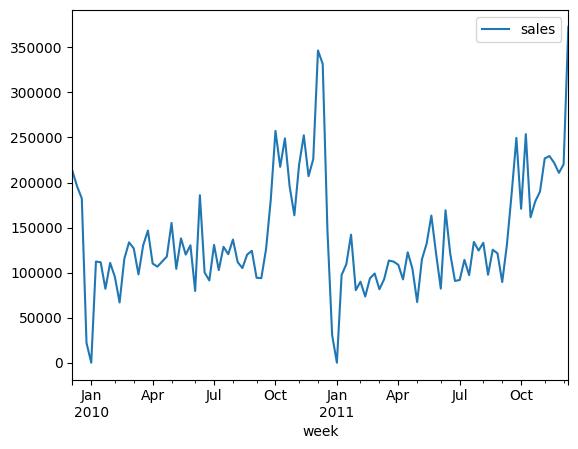

In [3]:
_=df.plot()

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

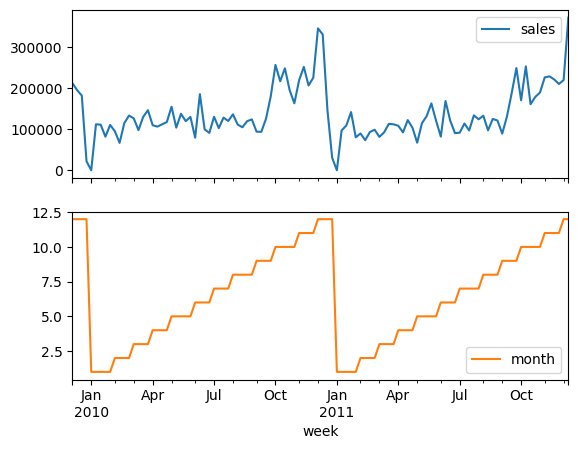

In [4]:
# Create the feature month from the timestamp.
dtf = DatetimeFeatures(
    # the dateime variable
    variables="index",

    # the features we want to create
    features_to_extract=[
    "month"
    ]
)

# Demo of dft
_=dtf.fit_transform(df).plot(subplots=True)

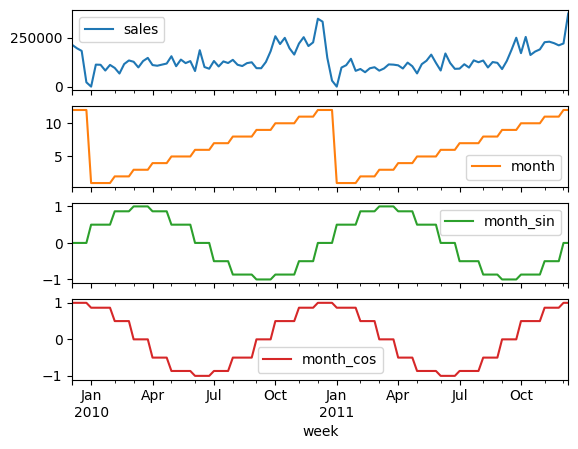

In [5]:
# Transform the month with the sine and cosine functions
cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month"],
    # Whether to drop the original features.
    drop_original=False,
)
# Demo of dft and cyclicf
_=cyclicf.fit_transform(dtf.fit_transform(df)).plot(subplots=True)

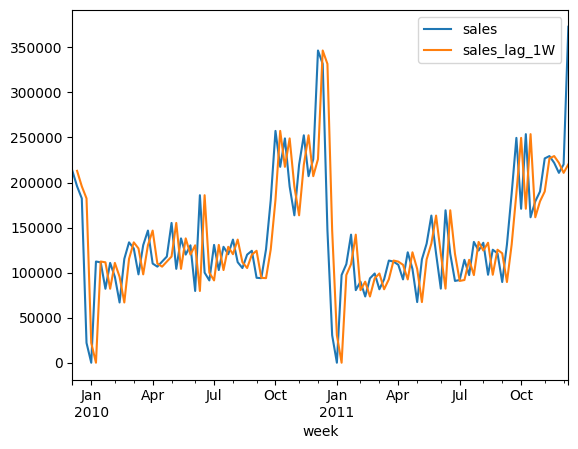

In [6]:
# Create the feature lag-1 by lagging 1 week of data.
# Check https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
# to know about the strings that can be entered for the freq argument.
lagf = LagFeatures(
    variables=['sales'], # The input variables
    freq=["1W"], # move 7 days (or one week) forward
    missing_values="ignore"
)
# Demo of just lagf
_=lagf.fit_transform(df).plot(subplots=False)

In [7]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.

winf = WindowFeatures(
    variables=['sales'], # the input variables
    window=["14D", "28D"], # average, max, and min of previous 2 and 4 weeks
    freq="7D", # move 1 week forward
    functions=['min', 'mean', 'max'],
    missing_values="ignore",
)
# Demo of winf
winf.fit_transform(lagf.fit_transform(df)).head()

,sales,sales_lag_1W,sales_window_14D_min,sales_window_14D_mean,sales_window_14D_max,sales_window_28D_min,sales_window_28D_mean,sales_window_28D_max
week,,,,,,,,
2009-12-06,213000.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.04,213000.35,213000.35,213000.350,213000.35,213000.35,213000.350000,213000.35
2009-12-20,182396.74,195810.04,195810.04,204405.195,213000.35,195810.04,204405.195000,213000.35
2009-12-27,22007.77,182396.74,182396.74,189103.390,195810.04,182396.74,197069.043333,213000.35
2010-01-03,0.00,22007.77,22007.77,102202.255,182396.74,22007.77,153303.725000,213000.35


In [8]:
# Drop missing data.
imputer = DropMissingData()
# Demo of lagf with imputer
imputer.fit_transform(lagf.fit_transform(df)).head()

,sales,sales_lag_1W
week,,
2009-12-13,195810.04,213000.35
2009-12-20,182396.74,195810.04
2009-12-27,22007.77,182396.74
2010-01-03,0.00,22007.77
2010-01-10,112318.85,0.00


Notice it dropped data point for '2009-12-06'

In [9]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop=['sales'])
# Demo for lagf, imputer, and drop_ts
drop_ts.fit_transform(imputer.fit_transform(lagf.fit_transform(df))).head()

,sales_lag_1W
week,
2009-12-13,213000.35
2009-12-20,195810.04
2009-12-27,182396.74
2010-01-03,22007.77
2010-01-10,0.00


## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [26]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']
df = df[df.index>='2010-01-03']
df.head()

,sales
week,
2010-01-03,0.000
2010-01-10,112318.850
2010-01-17,111460.470
2010-01-24,82065.331
2010-01-31,110790.591


In [27]:
df.index.min(), df.index.max()

(Timestamp('2010-01-03 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [28]:
# The offset for the test set
# We have approx two years of data. Lets use last two months (2011-10-02 onwards) of data as test set, and rest of the past data as the training set (before 2011-10-02) 
# This makes '2011-10-02' as the first forecasting point. 
# Since the feature engineering step requires at least 4 weeks of data prior to the first forecasting point, our test data should start at '2011-10-02' - 4 weeks, which is '2011-09-4'
pd.Timestamp('2011-10-02') - pd.offsets.Week(4)

Timestamp('2011-09-04 00:00:00')

In [29]:
# Split the data in time.
X_train = df[df.index < "2011-10-02"]
X_test = df[df.index >= pd.Timestamp('2011-10-02') - pd.offsets.Week(4)]

# Target
y_train = df[df.index < "2011-10-02"]["sales"]
y_test = df[df.index >= "2011-10-02"]["sales"]

In [30]:
# Let's check we have the correct data span
# in the test set:

X_test.index.min(), X_test.index.max()

(Timestamp('2011-09-04 00:00:00'), Timestamp('2011-12-11 00:00:00'))

## Machine Learning

In [31]:
# Feature engineering pipeline
pipe = Pipeline(
    [
        ("datetime_features", dtf), # adds year of the month as a feature
        ("periodic", cyclicf), # Add sine and cosine transforms to the month feature to capture periodicity
        ("lagf", lagf), # Adds one week's lag as a feature\
        ("winf", winf), # Adds window features: mean, min, and max sales in the last 2 and 4 weeks
        ("dropna", imputer), # Drops NaN rows that get introduced due to lag feature
        ("drop_ts", drop_ts), # Drops sales since it is the target
    ]
)

X_train_t = pipe.fit_transform(X_train)
X_test_t = pipe.transform(X_test)

# Data with input features.
X_train_t.head()

,month,month_sin,month_cos,sales_lag_1W,sales_window_14D_min,sales_window_14D_mean,sales_window_14D_max,sales_window_28D_min,sales_window_28D_mean,sales_window_28D_max
week,,,,,,,,,,
2010-01-10,1,0.500000,0.866025,0.000,0.000,0.0000,0.000,0.000,0.000000,0.00
2010-01-17,1,0.500000,0.866025,112318.850,0.000,56159.4250,112318.850,0.000,56159.425000,112318.85
2010-01-24,1,0.500000,0.866025,111460.470,111460.470,111889.6600,112318.850,0.000,74593.106667,112318.85
2010-01-31,1,0.500000,0.866025,82065.331,82065.331,96762.9005,111460.470,0.000,76461.162750,112318.85
2010-02-07,2,0.866025,0.500000,110790.591,82065.331,96427.9610,110790.591,82065.331,104158.810500,112318.85


In [32]:
# First data point from the training set got dropped because 1st lag. Same record needs to be dropped from the training target as well.
y_train_t = y_train[X_train_t.index]

In [33]:
# Training and testing

linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train_t, y_train_t)

# Performance of linear model
y_pred_train = linear_model.predict(X_train_t)
print("train rmse: ", mean_squared_error(y_true=y_train_t, y_pred=y_pred_train, squared=False))

y_pred =  linear_model.predict(X_test_t)
# There are 3 additional data points in y_pred because last 4 data points of the training set were also kept in the test set to appropriately compute the 4W window feature. 
# The feature engineering pipeline drops the first data point because it contains NaNs, however it retains the remaining 3.
# These three were part of the training set hence they need to be dropped from y_pred before computing the test rmse.
y_pred = y_pred[3:]
print("test rmse: ",  mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False))

train rmse:  34787.64928578444
test rmse:  54634.85067737422
